# Aggregating Slice Results: Part 1

In this report, I will explore different ways of aggregating slice classification results, in order to evaluate fibrosis presence in patient, rather than individual slices.

This notebook already uses the optimization methods tested in `4.1 - pureVsConservative`:

 - resize before augmentations 
 - pure lowest validation loss value model choice

In [1]:
# ------------ Utils ------------

from aggregateUtils import * 

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce RTX 3070
Device 0: NVIDIA GeForce RTX 3070


In [3]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')

In [4]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


## <span style= "color:red"> WARNING </span>

This `FibrosisDataset` class differs from the previous implementations, as it is used in slice aggregation classification, through initialization and return of the `patient_id` variable.

In [5]:
def getPatientID(s):
    # HRCT_Pilot__PatientID
    match = re.search(r'HRCT_Pilot__(\d+)__', s)
    if match: return match.group(1)
        
    # PatientID__sliceSpecific
    match = re.match(r'(\d+)__', s)
    if match:
        return match.group(1)
    return None  

In [6]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label, patient_id

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

## Training

In [7]:
def trainResNet(train_dataset, val_dataset, num_epochs=90, batch_size=32, lr=5e-7, patience=5, improve_min=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels, patient_id in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels, patient_id in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return best_model_pure, epoch_pure, loss_array, val_loss_array

In [8]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [9]:
class ResNetFeat(ResNet):
    def _forward_impl_feat(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

NameError: name 'ResNet' is not defined

In [ ]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    """
    # Setup ResNet for Reading
    resnet_eval = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    

    # Use only 2 output neurons
    num_ftrs = resnet_eval.fc.in_features
    resnet_eval.fc = nn.Linear(num_ftrs, 2)

    # Load weights
    resnet_eval.load_state_dict(checkpoint['model_state_dict'])

    """

    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate_correct_val.pkl"))


else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


Epoch [1/90], Train loss: 1.761093
Validation loss: 1.773803


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/90], Train loss: 1.716765
Validation loss: 1.740975


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


Epoch [3/90], Train loss: 1.649479
Validation loss: 1.709913


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [4/90], Train loss: 1.623959
Validation loss: 1.679425


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]


Epoch [5/90], Train loss: 1.583165
Validation loss: 1.649530


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [6/90], Train loss: 1.542502
Validation loss: 1.620261


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]


Epoch [7/90], Train loss: 1.479939
Validation loss: 1.591554


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]


Epoch [8/90], Train loss: 1.444092
Validation loss: 1.563575


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]


Epoch [9/90], Train loss: 1.428548
Validation loss: 1.537376


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [10/90], Train loss: 1.388112
Validation loss: 1.510553


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [11/90], Train loss: 1.334750
Validation loss: 1.484437


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [12/90], Train loss: 1.309097
Validation loss: 1.459204


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [13/90], Train loss: 1.257497
Validation loss: 1.434439


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [14/90], Train loss: 1.243751
Validation loss: 1.410497


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [15/90], Train loss: 1.211733
Validation loss: 1.386133


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [16/90], Train loss: 1.175481
Validation loss: 1.362766


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [17/90], Train loss: 1.149525
Validation loss: 1.339975


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [18/90], Train loss: 1.116662
Validation loss: 1.317018


Training...: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/90], Train loss: 1.087388
Validation loss: 1.294421


Training...: 100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Epoch [20/90], Train loss: 1.035455
Validation loss: 1.272607


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [21/90], Train loss: 0.996531
Validation loss: 1.252308


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [22/90], Train loss: 1.002051
Validation loss: 1.231634


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [23/90], Train loss: 0.968080
Validation loss: 1.210220


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [24/90], Train loss: 0.941758
Validation loss: 1.190355


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


Epoch [25/90], Train loss: 0.925044
Validation loss: 1.170318


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [26/90], Train loss: 0.895632
Validation loss: 1.149545


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [27/90], Train loss: 0.861915
Validation loss: 1.131278


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [28/90], Train loss: 0.843736
Validation loss: 1.112350


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [29/90], Train loss: 0.818504
Validation loss: 1.094428


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [30/90], Train loss: 0.796278
Validation loss: 1.076662


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [31/90], Train loss: 0.771563
Validation loss: 1.059710


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [32/90], Train loss: 0.756515
Validation loss: 1.042152


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [33/90], Train loss: 0.722529
Validation loss: 1.025524


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [34/90], Train loss: 0.706750
Validation loss: 1.010520


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [35/90], Train loss: 0.694475
Validation loss: 0.994585


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [36/90], Train loss: 0.662299
Validation loss: 0.979466


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


Epoch [37/90], Train loss: 0.661238
Validation loss: 0.964359


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [38/90], Train loss: 0.638762
Validation loss: 0.949813


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [39/90], Train loss: 0.625183
Validation loss: 0.935037


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [40/90], Train loss: 0.618792
Validation loss: 0.920453


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [41/90], Train loss: 0.592043
Validation loss: 0.904825


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [42/90], Train loss: 0.580180
Validation loss: 0.893219


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [43/90], Train loss: 0.558072
Validation loss: 0.878871


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


Epoch [44/90], Train loss: 0.547259
Validation loss: 0.866463


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [45/90], Train loss: 0.530780
Validation loss: 0.853462


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [46/90], Train loss: 0.498409
Validation loss: 0.841943


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [47/90], Train loss: 0.503212
Validation loss: 0.831905


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [48/90], Train loss: 0.480625
Validation loss: 0.821013


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [49/90], Train loss: 0.474800
Validation loss: 0.810656


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


Epoch [50/90], Train loss: 0.470310
Validation loss: 0.799720


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [51/90], Train loss: 0.449755
Validation loss: 0.789064


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [52/90], Train loss: 0.440858
Validation loss: 0.779006


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [53/90], Train loss: 0.430106
Validation loss: 0.768322


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [54/90], Train loss: 0.426334
Validation loss: 0.759171


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [55/90], Train loss: 0.396261
Validation loss: 0.749746


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [56/90], Train loss: 0.403273
Validation loss: 0.740786


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [57/90], Train loss: 0.398383
Validation loss: 0.731580


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [58/90], Train loss: 0.362962
Validation loss: 0.722951


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [59/90], Train loss: 0.373109
Validation loss: 0.716518


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [60/90], Train loss: 0.347422
Validation loss: 0.708632


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [61/90], Train loss: 0.369242
Validation loss: 0.700937


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [62/90], Train loss: 0.346179
Validation loss: 0.693056


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [63/90], Train loss: 0.347137
Validation loss: 0.684335


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


Epoch [64/90], Train loss: 0.321893
Validation loss: 0.676516


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [65/90], Train loss: 0.334059
Validation loss: 0.668601


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [66/90], Train loss: 0.311662
Validation loss: 0.663640


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


Epoch [67/90], Train loss: 0.297187
Validation loss: 0.657423


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


Epoch [68/90], Train loss: 0.297668
Validation loss: 0.651885


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [69/90], Train loss: 0.301091
Validation loss: 0.644596


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [70/90], Train loss: 0.287989
Validation loss: 0.639044


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [71/90], Train loss: 0.296923
Validation loss: 0.631682


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [72/90], Train loss: 0.271791
Validation loss: 0.625840


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [73/90], Train loss: 0.285895
Validation loss: 0.619938


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [74/90], Train loss: 0.277025
Validation loss: 0.612659


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


Epoch [75/90], Train loss: 0.263635
Validation loss: 0.605934


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [76/90], Train loss: 0.256144
Validation loss: 0.601972


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [77/90], Train loss: 0.249871
Validation loss: 0.597158


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [78/90], Train loss: 0.251332
Validation loss: 0.590979


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [79/90], Train loss: 0.234732
Validation loss: 0.586201


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [80/90], Train loss: 0.237000
Validation loss: 0.583247


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [81/90], Train loss: 0.215780
Validation loss: 0.580619


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [82/90], Train loss: 0.223655
Validation loss: 0.576070


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [83/90], Train loss: 0.220146
Validation loss: 0.572095


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [84/90], Train loss: 0.217345
Validation loss: 0.570678


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [85/90], Train loss: 0.216996
Validation loss: 0.566567


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [86/90], Train loss: 0.199176
Validation loss: 0.562202


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]


Epoch [87/90], Train loss: 0.196742
Validation loss: 0.560302


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Epoch [88/90], Train loss: 0.200147
Validation loss: 0.557133


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Epoch [89/90], Train loss: 0.195584
Validation loss: 0.553118


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


Epoch [90/90], Train loss: 0.193582
Validation loss: 0.548629


In [11]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_aggregate_correct_val.pkl"))

else: print("DID NOT SAVE")

# Results and Aggregation Methods

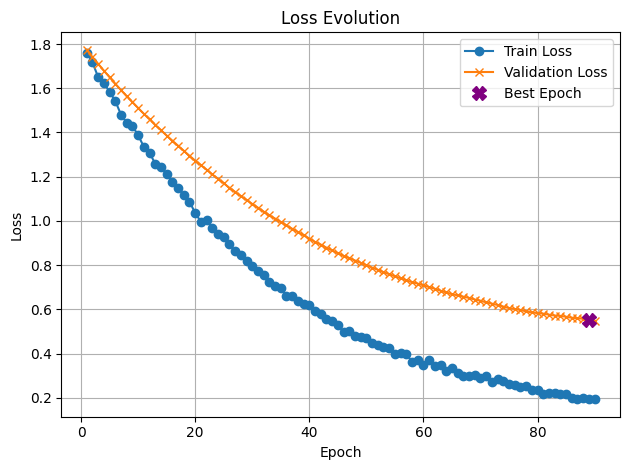

Best Validation Loss:  0.5486293651840903


In [12]:
plotLoss(custom_loss, custom_val_loss, best_epoch)
print("Best Validation Loss: ",custom_val_loss[best_epoch])

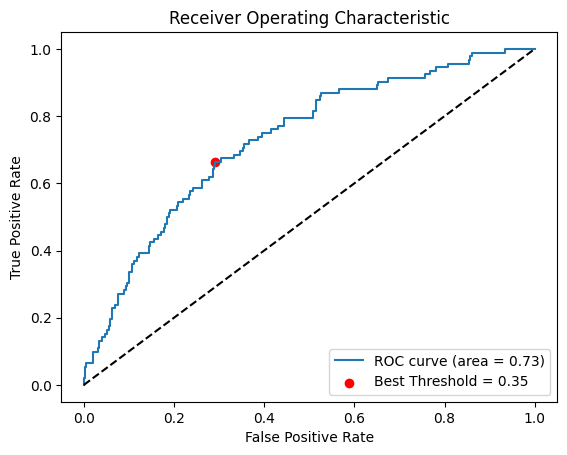

Area Under Curve: 0.7306503772906935
Best Threshold (closest to (0,1)): 0.3493302


In [13]:
threshold_eval, auc_eval = getROC(resnet_eval, val_dataset)

In [14]:
def evalResNet(resnet18, test_dataset, threshold):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []

    # for feature based
    #lat=resnet.define_hook(fc)

    with torch.no_grad():
        for images, labels, patient_id in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")


    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [15]:
evalResNet(resnet_eval, test_dataset,threshold_eval)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 62.88%  (354 in 563)
Accuracy for Class 1: 82.35%  (70 in 85)
Test Accuracy: 65.43%
Weighted Accuracy: 79.76%

 --------------------- 

F1 Score (Macro): 0.572
F1 Score (Weighted): 0.710
F1 Score Class 0: 0.760
F1 Score Class 1: 0.385

 --------------------- 


Confusion Matrix: 
 [[354 209]
 [ 15  70]]


## Patient-wise Classification

This will be done through aggregation of the probabilities determined by the resnet for each slice.

My plan is to create:
 - a dictionary containing keys as "PatientID" and values as arrays of probabilities. 
 - another dictionary containing the same keys, but with binary classification value arrays.

### <span style = "color:red"> WARNING  </span>

It's also important to re-define the best threshold, as the one obtained above was meant for slice-level classification. Aditionally, a new, individual best threshold must be determined for each aggregation criteria.

However, this introduces a challenge in implementation. In order to find the best threshold for the "majority_vote" and "n_is_enough" methods, **I already need a threshold prior to finding the best AUC-ROC**. This is recursive-variable-dependecy problem.

#### How can I mitigate this issue?

 - Instead of finding an optimal threshold, I will **choose the classification with the highest likelyhood/probability, as per determined by the model**.
 - **Performing a sweep** of best thresholds based on the **best mean threshold**.

After discussing with supervisors, the first option was chosen as the best candidate.

In [16]:
def getMaxSliceNumber(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    patient_prob = {}
    for images, labels, patient_id in loader:
        images, labels = images.to(device), labels.to(device)

        for pid, slice, label in zip(patient_id, images.tolist(), labels.tolist()):
                # Initializes key:value pair if it doesn't exist
                if pid not in patient_prob: patient_prob[pid] = 1  
                patient_prob[pid] += 1

    return max(patient_prob.values())

In [18]:
def getROCAggregate(model, dataset, threshold, aggregate_criteria="mean", show_plot=True): 

    all_labels, all_scores = [], []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Needed for patient-wise classification
    patient_prob = {}
    patient_class = {}

    model.eval()
    with torch.no_grad():
        for images, labels, patient_id in loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = model(images)

            # Translate logits to probabilities using softmax
            # and then chooses only values for Class 1 (0 or 1)
            probs = F.softmax(outputs, dim=1)[:, 1] 
        
            # Associate probabilities/values to dictionary for each patient
            for pid, prob, label in zip(patient_id, probs.tolist(), labels.tolist()):
                if pid not in patient_prob:
                    patient_prob[pid] = []  # Initializes key:value pair if it doesn't exist
                    patient_class[pid] = 0  # Sets classification as 0 until otherwise

                patient_prob[pid].append(prob)  # Adds probability to list
                
                # Label aggregation condition
                if label == 1: patient_class[pid] = 1 # Updates Classification
    
    # 2. After pulling every slice value for every patient, apply aggregate_criteria
    # and evaluate the aggregated values using criteria-specific conditions
    for id, prob_list in patient_prob.items():
        if aggregate_criteria == "mean":
            final_prob = np.mean(prob_list)
        
        # Absolute and Relative slice ammount thresholds (number of slices vs ratio)
        elif aggregate_criteria == "ratio" or aggregate_criteria == "n_is_enough":
            
            # Obtain fibrosis ratio
            ctr0,ctr1 = 0,0
            for prob in prob_list:
                slice_class = int(prob >= threshold)
                if slice_class == 1: ctr1 +=1
                else: ctr0 +=1

            final_prob = (ctr1/(ctr1+ctr0)) if aggregate_criteria == "ratio" else ctr1

        label = patient_class[id]

        #  y_true, y_pred -> all_scores, all_labels
        all_labels.append(label)
        all_scores.append(final_prob)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    if show_plot:
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold for method {aggregate_criteria} = {best_threshold:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        print("Area Under Curve:", roc_auc)
        print("Best Threshold (closest to (0,1)):", best_threshold)

    return best_threshold, roc_auc

### Getting Test Threshold: `mean`

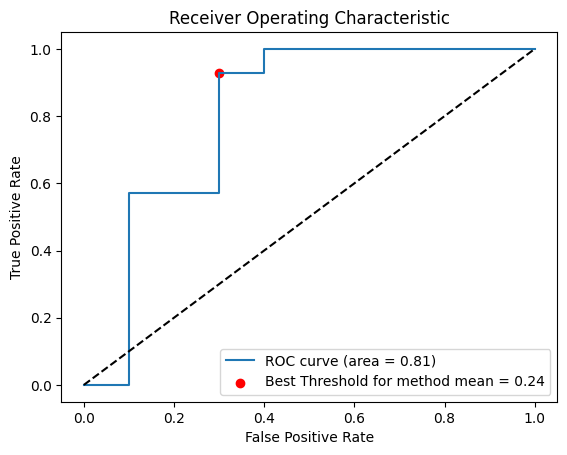

Area Under Curve: 0.8071428571428572
Best Threshold (closest to (0,1)): 0.23716810904443264


In [19]:
mean_thresh, mean_roc_auc = getROCAggregate(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="mean")

### Getting Test Threshold: `ratio`

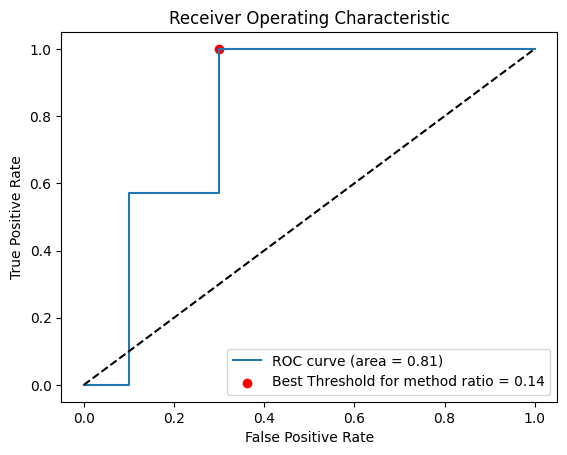

Area Under Curve: 0.8142857142857143
Best Threshold (closest to (0,1)): 0.13636363636363635


In [20]:
rat_thresh, rat_roc_auc = getROCAggregate(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="ratio")

### Getting Test Threshold: `n_is_enough`

The threshold for this method corresponds to the optimal number of slices.

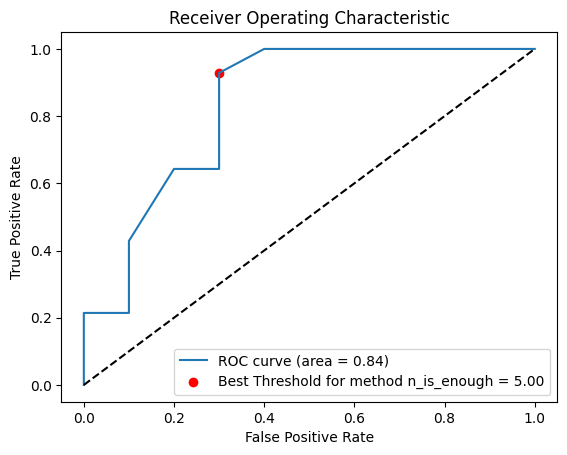

Area Under Curve: 0.8357142857142857
Best Threshold (closest to (0,1)): 5.0


In [21]:
n_thresh, n_roc_auc = getROCAggregate(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="n_is_enough")

# Testing Aggregation Methods

In [22]:
def evalPatientProbResNet(resnet18, test_dataset, threshold, aggregate_criteria="mean", n=1, ratio= 0.5, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []

    # Needed for patient-wise classification
    patient_prob = {}
    patient_class = {}

    # Used to store values after aggregation
    patient_aggregate = {}


    # 1. This loop populates dictionaries with values pulled from the model
    with torch.no_grad():
        for images, labels, patient_id in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Associate probabilities to dictionary for each patient
            for pid, prob, label in zip(patient_id, probs.tolist(), labels.tolist()):
                if pid not in patient_prob:
                    patient_prob[pid] = []  # Initializes key:value pair if it doesn't exist
                    patient_class[pid] = 0  # Same principle

                patient_prob[pid].append(prob)  # Adds probability to list
                
                # Label aggregation condition
                if label == 1: patient_class[pid] = 1 
                       
    
    # 2. After pulling every slice value for every patient, apply aggregate_criteria
    # and evaluate the aggregated values using criteria-specific conditions
    for id, prob_list in patient_prob.items():
        if aggregate_criteria == "mean":
            prob = np.mean(prob_list)
            patient_aggregate[id] = prob

            # If larger -> True -> int -> 1
            # If smaller -> False -> int -> 0
            predicted = int(prob >= threshold)

        # Absolute and Relative slice ammount thresholds (number of slices vs ratio)
        elif aggregate_criteria == "ratio" or aggregate_criteria == "n_is_enough":
            
            # Obtain fibrosis ratio
            ctr0,ctr1 = 0,0
            for prob in prob_list:
                slice_class = int(prob >= threshold)
                if slice_class == 1: ctr1 +=1
                else: ctr0 +=1

            # If ratio of slices == 1 is >= threshold_ratio 
            # OR if number of slices >= threshold_n 
            # THEN patient_classification == 1
            # 0 otherwise
            predicted = int((ctr1/(ctr1+ctr0)) >= ratio) if aggregate_criteria == "ratio" else int(ctr1>=n)

        label = patient_class[id]

        # Counters for metrics   
        total += 1
        if patient_class[id] == 0:
            total_class_0 += 1
            if predicted == patient_class[id]:
                correct_class_0 += 1
                correct += 1
        elif patient_class[id] == 1:
            total_class_1 += 1
            if predicted == patient_class[id]:
                correct_class_1 += 1
                correct += 1

        # Populate y_true and y_pred lists for F1 Score
        # print(id, patient_class[id])
        y_true.append(patient_class[id])
        y_pred.append(predicted)
        

    
    # Weights change here -> Class == 1 is the majority class
    weight_0, weight_1 = 14/24, 10/24

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    if correct_class_0 == total_class_0: accuracy_class_0 = 100

    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    if correct_class_1 == total_class_1: accuracy_class_1 = 100

    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    print("Labels:    ",y_true)
    print("Predicted: ", y_pred)
    # print(type(y_true), type(y_pred))


    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    if verbose:

        # Accuracy
        print("\n --------------------- \n")
        print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
        print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
        print(f"Test Accuracy: {accuracy:.2f}%")
        if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
        print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

        # F1 scores
        print("\n --------------------- \n")
        print(f"F1 Score (Macro): {f1_macro:.3f}")
        print(f"F1 Score (Weighted): {f1_weighted:.3f}")
        print(f"F1 Score Class 0: {f1_class_0:.3f}")
        print(f"F1 Score Class 1: {f1_class_1:.3f}")

        # Confusion matrix
        print("\n --------------------- \n")
        print("\nConfusion Matrix: \n", conf_mat)    

## Mean

In [23]:
evalPatientProbResNet(resnet_eval, test_dataset, mean_thresh)

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 92.86%  (13 in 14)
Test Accuracy: 83.33%
Weighted Accuracy: 79.52%

 --------------------- 

F1 Score (Macro): 0.822
F1 Score (Weighted): 0.830
F1 Score Class 0: 0.778
F1 Score Class 1: 0.867

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 1 13]]


The threshold defined for slice-based prediction optimization does not work well with the mean of all slice probabilities. Some probability values are much different then others, which prompted the mean to always be larger than the threshold, resulting in prediction of Class == 1 in 100% of the cases.

## N is enough

Aggregation technique with a customizable threshold for number of Class == 1 slices needed to consider fibrosis present in a patient.

After testing with absolute values, and taking into account that different patients will most likely have a different number of slices, I decided to implement both absolute and relative conditions:

 - if n is an integer **(absolute)**: if a patient displays at least n slices with Class == 1, then the patient is classified as Class == 1.
 - if n is a float **(ratio)**: if a patient displays at least n% slices with Class == 1, then the patient is classified as Class == 1.

### Absolute Value Tests 

#### Using `n_thresh`

In [25]:
evalPatientProbResNet(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="n_is_enough", n=n_thresh)

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 92.86%  (13 in 14)
Test Accuracy: 83.33%
Weighted Accuracy: 79.52%

 --------------------- 

F1 Score (Macro): 0.822
F1 Score (Weighted): 0.830
F1 Score Class 0: 0.778
F1 Score Class 1: 0.867

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 1 13]]


### Relative Value Tests

In [26]:
evalPatientProbResNet(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="ratio", ratio=rat_thresh)

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 100.00%  (14 in 14)
Test Accuracy: 87.50%
Weighted Accuracy: 82.50%

 --------------------- 

F1 Score (Macro): 0.863
F1 Score (Weighted): 0.870
F1 Score Class 0: 0.824
F1 Score Class 1: 0.903

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 0 14]]
